In [2]:
import numpy as np

In [3]:
import networkx as nx

In [21]:
import matplotlib.pyplot as plt
import random
import time
import math
from queue import PriorityQueue

In [6]:
#plt.subplot()

In [55]:
def givemedag(v,e,c):
    if e < v-1:
        print('边太少')
        return None
    #e大小要适量
    D = nx.DiGraph()
    leaves=[]
    while(True):
        nx.generators.directed.gn_graph(v-1,kernel = lambda x :x,create_using = D)
        tmp = [x[0] for x in list(D.in_degree()) if x[1] == 0]
        leafnum = len(tmp)
        if D.number_of_edges() + leafnum <= e:
            leaves = tmp.copy()
            break
    #nx.draw(D,with_labels=True)
    
    my_dict = nx.shortest_path_length(nx.reverse_view(D),source=0)
    mylst = list(zip(my_dict.values(), my_dict.keys()))
    #print(my_dict)
    #print(mylst)
    #print(leaves)
    D.add_node(v-1)
    for each in leaves:
        fea = [x[1] for x in mylst if x[0]>my_dict[each]]
        fea.append(v-1)
        D.add_edge(random.choice(fea),each)
    return D.reverse()

In [8]:
def allocation(dag,agentinfo,timelimit):
    basebid = {}
    relativebid = []
    welfare = 0.0
    for e in list(dag.edges):
        agentinfo[e].sort(key = lambda x:x[1])
        basebid[e] = agentinfo[e][0][0]
        nowbid = basebid[e]
        for i in range(len(agentinfo[e])):
            if i > 0 and agentinfo[e][i][0] > nowbid:
                nowbid = agentinfo[e][i][0]
                relativebid.append((agentinfo[e][i][0]-basebid[e],agentinfo[e][i][1],agentinfo[e][i][2],agentinfo[e][i][3]))
        dag.edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]
        welfare = welfare + agentinfo[e][0][0]
    #print(relativebid)
    #if nx.dag_longest_path_length(dag) > timelimit:
    #    print('mission impossible')
    #    return -1
    vis = {}
    relativebid.sort(key = lambda x:x[0])
    while relativebid != []:
        if len(vis) == dag.number_of_edges():
            break
        item = relativebid.pop()
        if item[2] in vis:
            continue
        tmp = dag.edges[item[2][0],item[2][1]]['weight']
        dag.edges[item[2][0],item[2][1]]['weight'] = item[1]
        if nx.dag_longest_path_length(dag) > timelimit:
            dag.edges[item[2][0],item[2][1]]['weight'] = tmp
            continue
        welfare = welfare + item[0]
        vis[item[2]] = True
    return welfare

In [9]:
def dfs(dag,ind,agentinfo,timelimit,welfare):
    if ind == dag.number_of_edges():
        if nx.dag_longest_path_length(dag) > timelimit:
            return -1
        return welfare
    te=list(dag.edges)[ind]
    ms = 0.0
    for x in agentinfo[te]:
        dag.edges[te[0],te[1]]['weight'] = x[1]
        ms = max(ms,dfs(dag,ind+1,agentinfo,timelimit,welfare+x[0]))
    return ms

In [10]:
def brute(dag,agent,timelimit):
    agentinfo = agent.copy()
    for e in list(dag.edges):
        agentinfo[e].sort(key = lambda x:x[1]) 
        filt = [agentinfo[e][i] for i in range(len(agentinfo[e]))if i == 0 or agentinfo[e][i][0] > agentinfo[e][i-1][0]]
        agentinfo[e] = filt
    return dfs(dag,0,agentinfo,timelimit,0)

In [38]:
def givemeagent(E, C):
    agents = {}
    for e in E:
        ci = np.random.randint(1,C)
        agents[e]=[]
        for i in range(ci):
            bi = -1
            while bi < 0:
                bi = 1*np.random.randn()+50
            ti = -1
            while ti <0:
                ti = np.random.randint(1,100)
            agents[e].append((bi,ti,e,i))
    return agents

In [72]:
def check(n,C):
    aoe = givemedag(n,1000000000,3)
    assert nx.is_directed_acyclic_graph(aoe)
    #print(aoe.number_of_edges())
    #nx.draw(aoe,with_labels=True)

    es = list(aoe.edges)
    agents = givemeagent(es,C)
    ms = {}
    for e in es:
        agents[e].sort(key = lambda x:x[1])
        nowbid = agents[e][0][0]
        mis = agents[e][0][1]
        mas = agents[e][0][1]
        for i in range(len(agents[e])):
            if i > 0 and agents[e][i][0] > nowbid:
                nowbid = agents[e][i][0]
                mas = agents[e][i][1]
        ms[e] = (mis,mas)
    for e in es:
        aoe.edges[e[0],e[1]]['weight'] = ms[e][0]
    a = nx.dag_longest_path_length(aoe)

    for e in es:
        aoe.edges[e[0],e[1]]['weight'] = ms[e][1]
    b = nx.dag_longest_path_length(aoe)

    tl = np.random.randint(a,b+1)
    
    t0 = time.perf_counter()
    sf = allocation(aoe,agents,tl),
    
    return sf,time.perf_counter()-t0
    #return allocation(aoe,agents,tl),brute(aoe,agents,tl)

In [54]:
a,b = check(20,3)
print(a,b)

32
1617.0194272278704 1617.0194272278704


In [ ]:
lst = []
a = []
for x in range(10,10**3):
    print(x)
    a.append(x)
    c,d = check(x,10)
    lst.append(d)
plt.plot(a,lst)

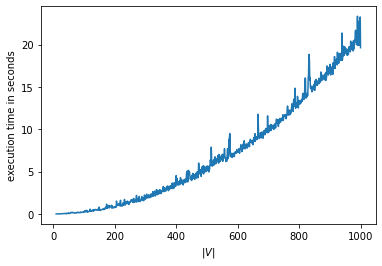

In [81]:
plt.xlabel('$|V|$')
plt.ylabel('execution time in seconds')
plt.plot(a,lst)
plt.savefig('exetime.pdf')
plt.show()

In [75]:
import pandas as pd

In [76]:
df = pd.DataFrame({'x':a,'y':lst})
df.to_csv('exetime10-1000.csv',index=False)

In [ ]:

testn=[10,15,20]
for x in testn:
    ratiolist = []
    cnt = 0
    for i in range(1000):
        print(i)
        a,b = check(x,3)
        if math.fabs(a-b) < 1e-8:
            cnt=cnt+1
        ratiolist.append(a/b)
        
        #print("a/b=%lf"%(a/b))
    print(cnt,np.median(ratiolist),np.mean(ratiolist),np.std(ratiolist,ddof=1))


In [ ]:
998 1.0 0.9999980277131707 5.478483267317938e-05

994 1.0 0.999998769926064 1.8107295551290027e-05
992 1.0 0.9999979986019756 2.9445272088786218e-05


In [ ]:
print(cnt,np.median(ratiolist),np.mean(ratiolist),np.std(ratiolist,ddof=1))

In [16]:
len(ratiolist)

1

In [8]:
x = range(10,10**3)

In [16]:
y1 = [i*(5*np.random.randn()+50)for i in x]

In [17]:
y2 = [i*(5*np.random.randn()+60)for i in x]

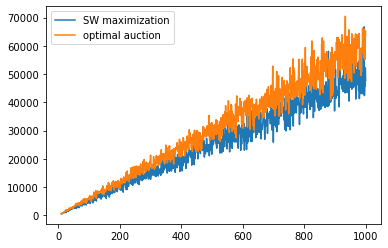

In [20]:
plt.plot(x,y1,label='SW maximization')
plt.plot(x,y2,label='optimal auction')
plt.legend(loc="upper left")

In [ ]:
plt.show()

In [22]:
def reweight(dag,agentinfo):
    for e in list(dag.edges):
        dag.edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]

In [23]:
def allocation2(dag,agentinfo,timelimit):
    #basebid = {}
    relativebid = [(agentinfo[e][i][0]-agentinfo[e][0][0],agentinfo[e][i][1],agentinfo[e][i][2],agentinfo[e][i][3])for e in list(dag.edges)for i in range(1,len(agentinfo[e]))]
    ansdict = {}
    reweight(dag,agentinfo)
    for e in list(dag.edges):
        #dag.edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]
        ansdict[e] = agentinfo[e][0][3]
    #print(relativebid)
    #if nx.dag_longest_path_length(dag) > timelimit:
    #    print('mission impossible')
    #    return -1
    vis = {}
    relativebid.sort(key = lambda x:x[0])
    while relativebid != []:
        if len(vis) == dag.number_of_edges():
            break
        item = relativebid.pop()
        if item[2] in vis:
            continue
        tmp = dag.edges[item[2][0],item[2][1]]['weight']
        dag.edges[item[2][0],item[2][1]]['weight'] = item[1]
        if nx.dag_longest_path_length(dag) > timelimit:
            dag.edges[item[2][0],item[2][1]]['weight'] = tmp
            continue
        vis[item[2]] = True
        ansdict[e] = item[3]
    return ansdict

In [43]:
def init(dag,agentinfo):
    for e in list(dag.edges):
        agentinfo[e].sort(key=lambda x:x[0],reverse=True)
        agentinfo[e].sort(key = lambda x:x[1]) 
        nowbid = agentinfo[e][0][0]
        tmp = [(agentinfo[e][0][0],agentinfo[e][0][1],agentinfo[e][0][2],0)]
        for i in range(1,len(agentinfo[e])):
            if agentinfo[e][i][0] > nowbid:
                nowbid = agentinfo[e][i][0]
                lens = len(tmp)
                tmp.append((agentinfo[e][i][0],agentinfo[e][i][1],agentinfo[e][i][2],lens))
        agentinfo[e] = tmp

In [65]:
def graphseq(dag,agentinfo,e,ind,relativebid,timelimit):
    reweight(dag,agentinfo)
    #cong tou qu 
    relativebid.sort(key = lambda x:x[0])
    vis = {}
    if ind > 0:
        addon = agentinfo[e][ind-1][0]-agentinfo[e][0][0]
        while relativebid != []:
            item = relativebid.pop()
            if item[2] in vis:
                continue
            if item[2] == e:
                if item[3] == ind - 1:
                    break
                else:
                    continue
            tmp = dag.edges[item[2][0],item[2][1]]['weight']
            dag.edges[item[2][0],item[2][1]]['weight'] = item[1]
            if nx.dag_longest_path_length(dag) > timelimit:
                dag.edges[item[2][0],item[2][1]]['weight'] = tmp
                continue
            vis[item[2]] = True
            dag.edges[e[0],e[1]]['weight'] = agentinfo[e][ind][1]
            if nx.dag_longest_path_length(dag) > timelimit:
                addon = item[0]
                break
            dag.edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]
        return addon+agentinfo[e][0][0]
    else:
        if len(agentinfo[e]) == 1:
            return 0
        graphs=[dag.copy()]
        bids=[0]
        que = PriorityQueue()
        while relativebid != []:
            item = relativebid.pop()
            if item[0] < agentinfo[e][1][0]:
                break
            if item[2] in vis:
                continue
            if item[2] == e:
                pre = len(bids)-1
                que.put((bids[pre]-item[0],pre,item[3]))
                continue
            tmp = dag.edges[item[2][0],item[2][1]]['weight']
            dag.edges[item[2][0],item[2][1]]['weight'] = item[1]
            if nx.dag_longest_path_length(dag) > timelimit:
                dag.edges[item[2][0],item[2][1]]['weight'] = tmp
                continue
            vis[item[2]] = True
            graphs.append(dag.copy())
            bids.append(item[0])
        acc = 0 #crucial
        addons = -1
        while not que.empty():
            front = que.get()
            if front[1] >= 1:
                delta = bids[front[1]]-(agentinfo[e][front[2]][0] + acc)
                acc = acc + delta
                if acc >= agentinfo[e][0][0]:
                    break
                newdist = max(0,bids[front[1]-1]-bids[front[1]])+ delta
                que.put((newdist,front[1]-1,front[2]))
            prepos = front[1]
            myind = front[2]
            graphs[prepos].edges[e[0],e[1]]['weight'] = agentinfo[e][myind][1]
            if nx.dag_longest_path_length(graphs[prepos]) <= timelimit: 
                addons = bids[prepos+1]-agentinfo[e][myind][0]
                break
            graphs[prepos].edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]
        if addons == -1:
            return 0
        return agentinfo[e][0][0]-addons

In [48]:
def payment(dag,agentinfo,timelimit):
    
    relativebid = [(agentinfo[e][i][0]-agentinfo[e][0][0],agentinfo[e][i][1],agentinfo[e][i][2],agentinfo[e][i][3])for e in list(dag.edges)for i in range(1,len(agentinfo[e]))]
    allo = allocation2(dag,agentinfo,timelimit)
    ans = 0.0
    for e in list(dag.edges):
        ans = ans + graphseq(dag,agentinfo,e,allo[e],relativebid,timelimit)
    print(ans)

In [58]:
def checkpay(n,C):
    aoe = givemedag(n,1000000000,3)
    assert nx.is_directed_acyclic_graph(aoe)
    #print(aoe.number_of_edges())
    nx.draw(aoe,with_labels=True)
    es = list(aoe.edges)
    agents = givemeagent(es,C)
    init(aoe,agents)
    #print(agents)
    ms = {}
    for e in es:
        ms[e] = (agents[e][0][1],agents[e][len(agents[e])-1][1])
    for e in es:
        aoe.edges[e[0],e[1]]['weight'] = ms[e][0]
    a = nx.dag_longest_path_length(aoe)
    
    for e in es:
        aoe.edges[e[0],e[1]]['weight'] = ms[e][1]
    b = nx.dag_longest_path_length(aoe)
    print(a,b)
    tl = np.random.randint(a,b+1)
    return payment(aoe,agents,tl)

{(0, 1): [(48.77545907160705, 98, (0, 1), 0)], (0, 2): [(50.15599907520799, 1, (0, 2), 0)], (0, 3): [(51.15237799125808, 28, (0, 3), 0)], (0, 4): [(51.13127203499475, 36, (0, 4), 0)], (0, 23): [(48.09379928318772, 70, (0, 23), 0)], (1, 10): [(50.16332958723904, 44, (1, 10), 0)], (1, 11): [(51.53939265343452, 48, (1, 11), 0)], (1, 12): [(51.187775980155386, 53, (1, 12), 0)], (1, 21): [(49.91353381633571, 52, (1, 21), 0)], (1, 58): [(49.68943125992744, 23, (1, 58), 0)], (1, 59): [(49.55684951422868, 39, (1, 59), 0), (50.69028461970136, 84, (1, 59), 1)], (1, 61): [(50.594087464455924, 21, (1, 61), 0), (51.14904238255187, 99, (1, 61), 1)], (1, 73): [(50.17353333340624, 1, (1, 73), 0), (51.935814304264284, 7, (1, 73), 1)], (1, 158): [(51.992967661267556, 26, (1, 158), 0)], (1, 165): [(48.8376574765374, 43, (1, 165), 0)], (1, 177): [(49.33570181156277, 53, (1, 177), 0)], (1, 188): [(49.86866569208697, 30, (1, 188), 0)], (2, 6): [(48.987747979579424, 84, (2, 6), 0), (49.20728853416959, 90, (2

51.28571442654298


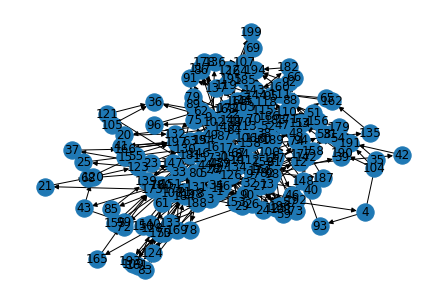

In [71]:
checkpay(200,3)

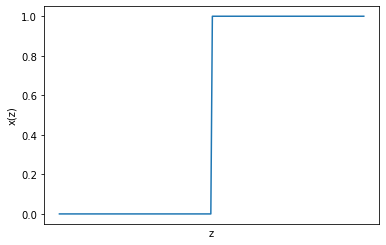

In [12]:
x = np.linspace(0,2,200)
z = np.zeros(100)
o = np.ones(100)
y = np.concatenate([z,o])
plt.xlabel('z')
plt.ylabel('x(z)')
plt.xticks([])
plt.plot(x,y)
plt.savefig('jieyuefenpei.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

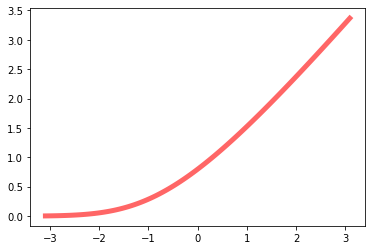

In [13]:
fig, ax = plt.subplots(1, 1)
from scipy.stats import norm
x = np.linspace(norm.ppf(0.001),
                norm.ppf(0.999), 100)
ax.plot(x, norm.pdf(x)/(1-norm.cdf(x)),
       'r-', lw=5, alpha=0.6, label='norm pdf')